# Test 2 - Jump Diffusion Data with Heavy Tails

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
keras = tf.keras 
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import norm, gaussian_kde, kurtosis
from sklearn.model_selection import train_test_split

from dh_framework import build_dh_model
from dh_loss_functions import VaR, CVaR, entropic
from dh_experiments import MertonJumpDiffusionPrice, set_global_seed, plot_training_curves, residual_error_statistics
from dh_data import generate_jump_diffusion_data

set_global_seed(42)

/Users/rugile/Pricing and Hedging Using Neural Networks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Generate jump diffusion data and verify heavy tails

In [2]:
# Generate jump diffusion data
price_paths, payoffs = generate_jump_diffusion_data(
    jump_int=10,
    mu_jump=0.75,
    sigma_jump=0.001,
    N=10**5,
    sigma=0.2,
    d=1,
    n=100,
    K=1.0,
    T=1.0,
    S=1.0
)

### Find kurtosis and the Hill Estimate

In [3]:
# Extract terminal prices
S_T = price_paths[:, -1, 0]

# Find kurtosis
print("Kurtosis of the terminal prices is ", kurtosis(S_T))

# Calculate the Hill estimator for the right tail
def hill_estimator(prices, k=1000, tail='right'):
    sorted_prices = np.sort(prices)
    if tail == 'right':
        tail_prices = sorted_prices[-k:]
        logs = np.log(tail_prices)-np.log(tail_prices[0])
    else:
        tail_prices = sorted_prices[:k]
        logs = np.log(tail_prices[-1])-np.log(tail_prices)
    return 1.0/np.mean(logs)

print(f"Hill estimator for the right tail is {hill_estimator(S_T, tail='right')}")

Kurtosis of the terminal prices is  39.61330263070434
Hill estimator for the right tail is 3.876555793221526


### Visualize the heavy tails

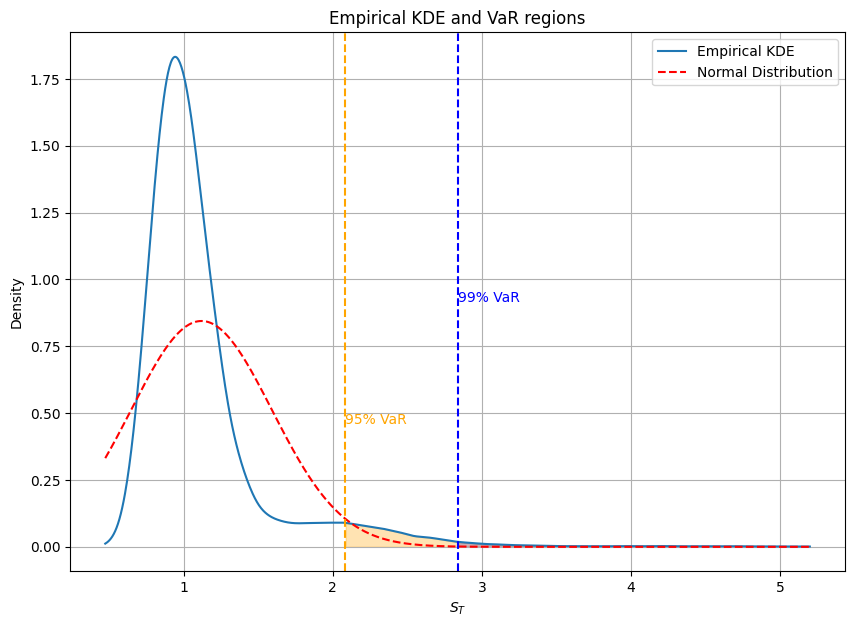

In [4]:
# KDE
kde = gaussian_kde(S_T)
x_vals = np.linspace(np.percentile(S_T,0.01), np.percentile(S_T,99.9),1000)
empirical_kde = kde(x_vals)

# Gaussian fit
mu, std = np.mean(S_T), np.std(S_T)
gaussian_pdf = norm.pdf(x_vals, loc=mu, scale=std)

plt.figure(figsize=(10,7))
plt.plot(x_vals, empirical_kde, label="Empirical KDE")
plt.plot(x_vals, gaussian_pdf, 'r--', label="Normal Distribution")
plt.title('Empirical KDE and VaR regions')

# Shading quantiles
q95 = np.percentile(S_T,95)
q99 = np.percentile(S_T,99)
plt.fill_between(x_vals, 0, empirical_kde, where=(x_vals>=q99), color='blue',alpha=0.3)
plt.fill_between(x_vals, 0, empirical_kde, where=(x_vals>=q95), color='orange', alpha=0.3)
plt.axvline(q99, color='blue',linestyle='--')
plt.axvline(q95, color='orange',linestyle='--')
plt.text(q99, max(empirical_kde)*0.5, "99% VaR", color='blue')
plt.text(q95, max(empirical_kde)*0.25, "95% VaR", color='orange')

plt.xlabel("$S_T$"); plt.ylabel('Density')
plt.legend(); plt.grid(True); plt.show()

## Train the model

In [5]:
# Split data into training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(
    price_paths, payoffs,
    test_size = 0.2,        # 20% of data is used for testing
    random_state = 42,
    shuffle = True
)

# Initialize lists
losses = ['mse', VaR(alpha=0.05), CVaR(alpha=0.05), entropic(beta = 1.5)]
titles = ['MSE', 'VaR', 'CVaR', 'Entropic']
histories = []
models = []
premiums = []
hedges = []
times = []

# Define the learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps = 1000,
    decay_rate = 0.96,
    staircase = True
)

# Define an early stop
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [6]:
# Training Loop

for i, lossfn in enumerate(losses):
    keras.backend.clear_session()
    print(f"\nTraining model with {titles[i]} loss.")

    model, Premium_Network, Hedging_Networks = build_dh_model(
        d = 1,
        hidden_nodes = 16,
        L = 5,
        n = 100
    )

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
        loss = lossfn
    )

    start = tf.timestamp()          # Track training time
    history = model.fit(
        x=xtrain, y=ytrain,
        epochs = 50,
        batch_size = 1024,
        validation_split = 0.1,     # Use a validation set
        callbacks = early_stop,
        verbose = False
    )
    time = tf.timestamp() - start   # Total training time

    hedge = model.predict(xtest, verbose = 0)
    premium = float(Premium_Network(tf.ones([1,1])).numpy().squeeze())

    models.append(model)
    premiums.append(premium)
    histories.append(history)
    hedges.append(hedge)
    times.append(float(time))


Training model with MSE loss.

Training model with VaR loss.

Training model with CVaR loss.

Training model with Entropic loss.


## View results

To see if the heavy-tailed prices indeed induce heavy-tailed loss distributions, essential for showcasing the limitations of VaR, we check that the loss distributions are indeed heavy-tailed.

MSE: Kurtosis = 182.16, Hill estimator = 3.63
VaR: Kurtosis = 19.72, Hill estimator = 3.74
CVaR: Kurtosis = 1.23, Hill estimator = 3.81
Entropic: Kurtosis = 714.28, Hill estimator = 2.73


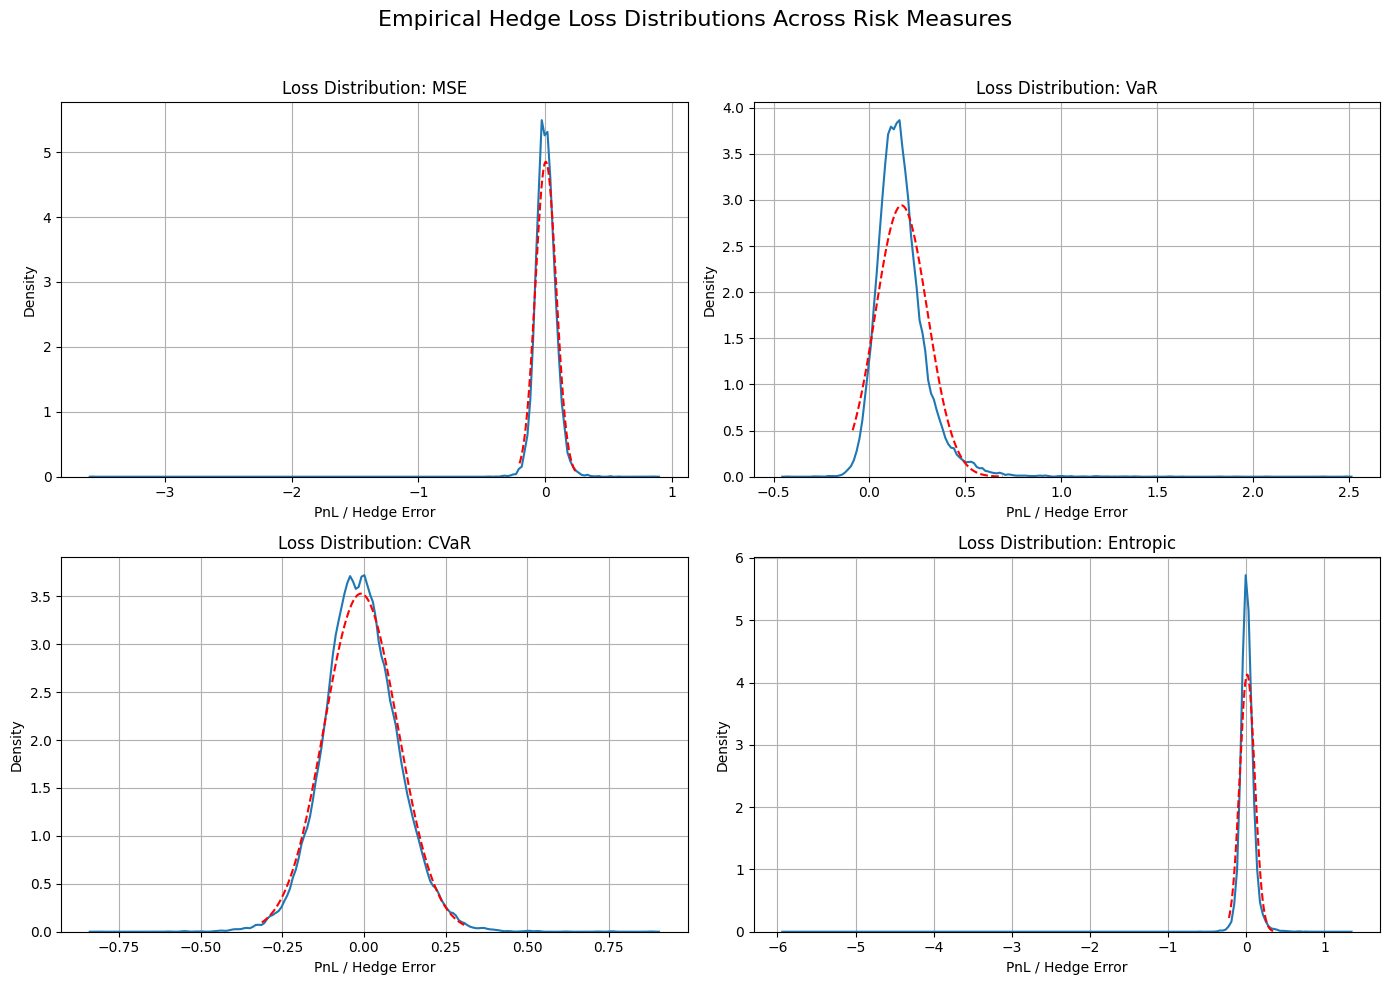

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i in range(len(titles)):
    losses_i = ytest[:, 0] - hedges[i][:, 0]

    # KDE plot
    sns.kdeplot(losses_i, bw_adjust=0.5, ax=axs[i])

    # Gaussian
    mu, std = np.mean(losses_i), np.std(losses_i)
    x_vals = np.linspace(np.percentile(losses_i, 0.5), np.percentile(losses_i, 99.5), 500)
    axs[i].plot(x_vals, norm.pdf(x_vals, loc=mu, scale=std), 'r--', label="Gaussian KDE")

    axs[i].set_title(f"Loss Distribution: {titles[i]}")
    axs[i].set_xlabel("PnL / Hedge Error")
    axs[i].grid(True)

    # Compute and print kurtosis
    kurt = kurtosis(losses_i, fisher=True)
    hill = hill_estimator(losses_i)
    print(f"{titles[i]}: Kurtosis = {kurt:.2f}, Hill estimator = {hill:.2f}")

plt.suptitle("Empirical Hedge Loss Distributions Across Risk Measures", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

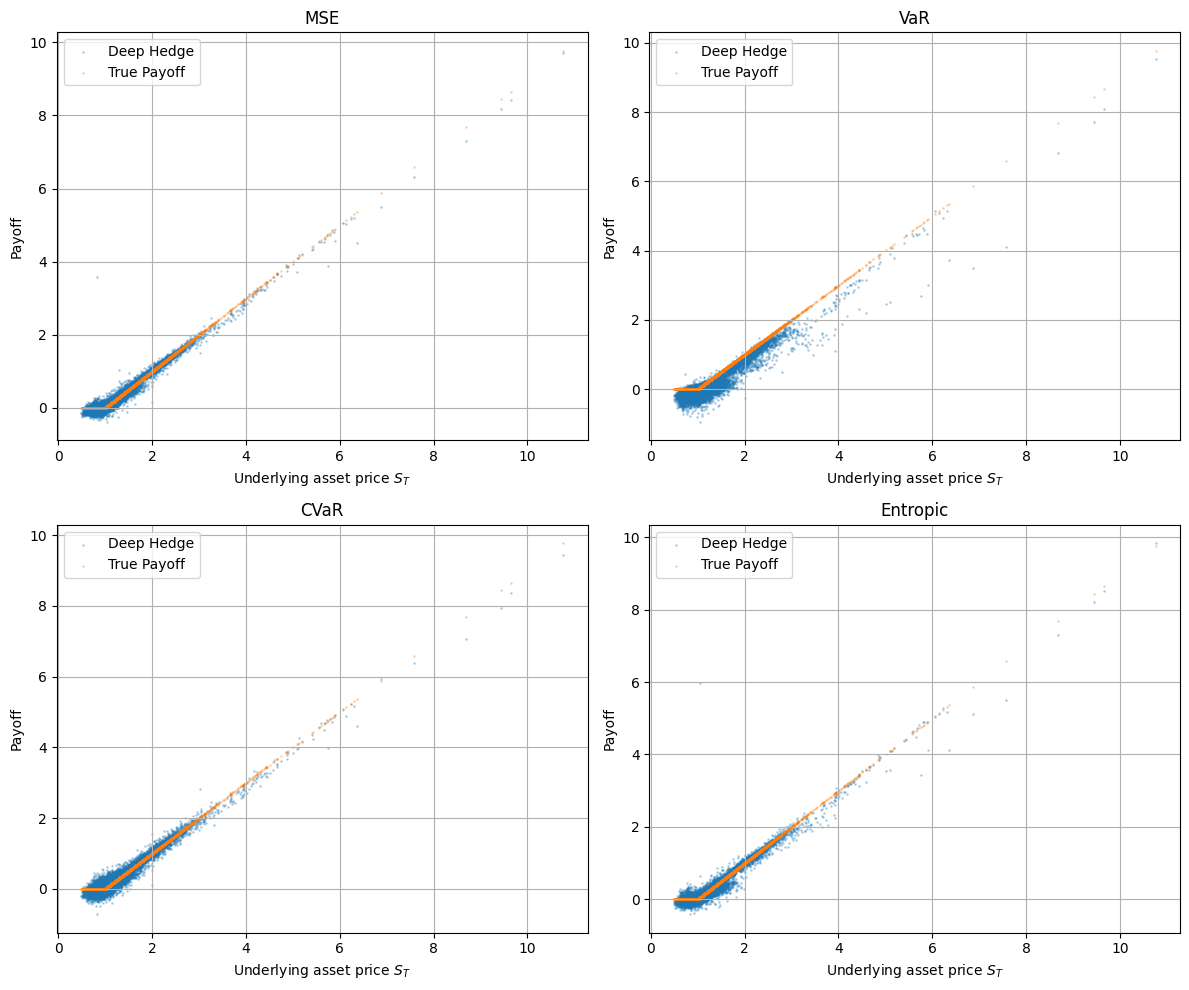


---- Model Premiums ----
MSE Premium: 0.10355181, with error 0.06391845
VaR Premium: -0.01336549, with error -0.05299885
CVaR Premium: 0.13742767, with error 0.09779432
Entropic Premium: 0.08945036, with error 0.04981700

---- Training Times ----
Training MSE took 109.49 seconds
Training VaR took 118.60 seconds
Training CVaR took 109.72 seconds
Training Entropic took 89.27 seconds


In [ ]:
# Plot learned hedge v. payoff
fig, axes = plt.subplots(2,2,figsize = (12,10))

for i, ax in enumerate(axes.flat):
    ax.scatter(xtest[:,-1,0], hedges[i][:,0], s=1, alpha = 0.25, label = "Deep Hedge")
    ax.scatter(xtest[:,-1,0], ytest[:,0], s=1, alpha=0.25, label="True Payoff")
    ax.set_title(titles[i])
    ax.set_xlabel("Underlying asset price $S_T$")
    ax.set_ylabel("Payoff")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

MJDPremium = MertonJumpDiffusionPrice(
        jump_intensity=10,
        mu_jump=0.75,
        sigma_jump=0.001,
        S=1.0,
        K=1.0,
        T=1.0,
        sigma=0.2,
        r=0
)

print("\n---- Model Premiums ----")
for name,premium in zip(titles,premiums):
    print(f"{name} Premium: {premium:.8f}, with error {premium-MJDPremium:.8f}")

print("\n---- Training Times ----")
for name, time in zip(titles,times):
    print(f"Training {name} took {time:.2f} seconds")

## Plot training vs. validation curves

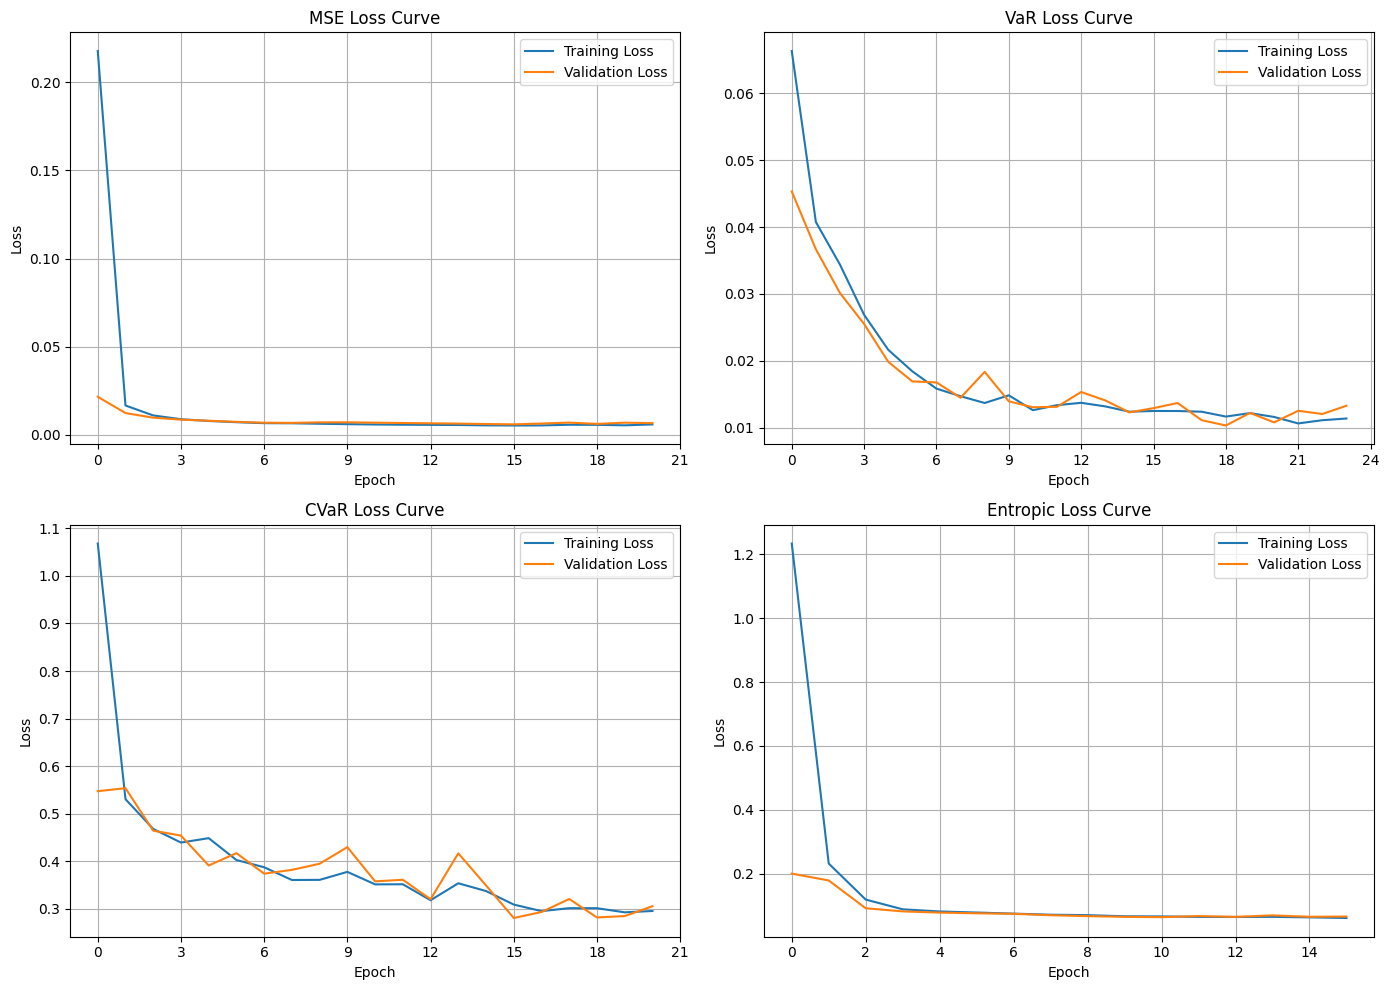

In [9]:
plot_training_curves(histories, titles)

## Residual Error Statistics

In [10]:
residual_error_statistics(hedges, ytest, titles)


--- Residual Error Statistics ---
MSE - mean residual: -0.004476, std:  0.082229
VaR - mean residual: -0.167317, std:  0.135672
CVaR - mean residual:  0.009031, std:  0.113089
Entropic - mean residual: -0.011759, std:  0.096645


## Average Hedging Error in the Right Tail

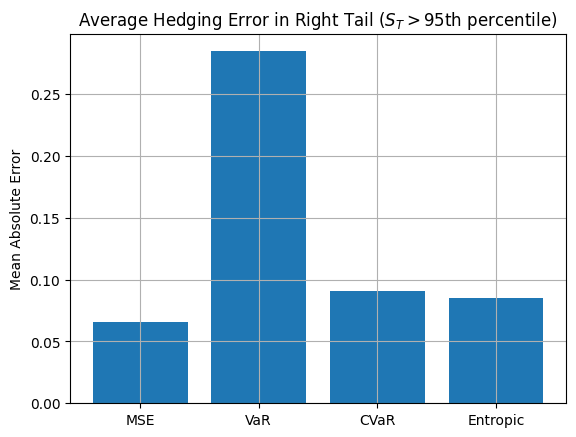

In [11]:
# Redefine S_T and q95 for test terminal prices
S_T = xtest[:,-1,0]
q95 = np.percentile(S_T,95)

# Absolute errors of each model
errors = {
    titles[i]: np.abs(hedges[i][:,0]-ytest[:,0])
    for i in range(len(titles))
}

# Right tail mask
mask = S_T > q95 

mean_errors_tail = {name: np.mean(err[mask]) for name,err in errors.items()}
plt.bar(mean_errors_tail.keys(), mean_errors_tail.values())
plt.ylabel("Mean Absolute Error")
plt.title("Average Hedging Error in Right Tail ($S_T > 95$th percentile)")
plt.grid(True)
plt.show()

## Frequency of large hedging errors

In [12]:
def extreme_loss_frequency(errors, threshold=0.5):
    return np.mean(errors[mask] > threshold)

# Print a summary table of errors larger than threshold
print("Frequency of Large Hedging Errors (> 0.5) in the Right Tail\n")
for name, err in errors.items():
    freq = extreme_loss_frequency(err)
    print(f"{name}: {freq:.2%}")

Frequency of Large Hedging Errors (> 0.5) in the Right Tail

MSE: 0.30%
VaR: 14.50%
CVaR: 0.60%
Entropic: 1.30%


## KDE of Right-Tail Errors

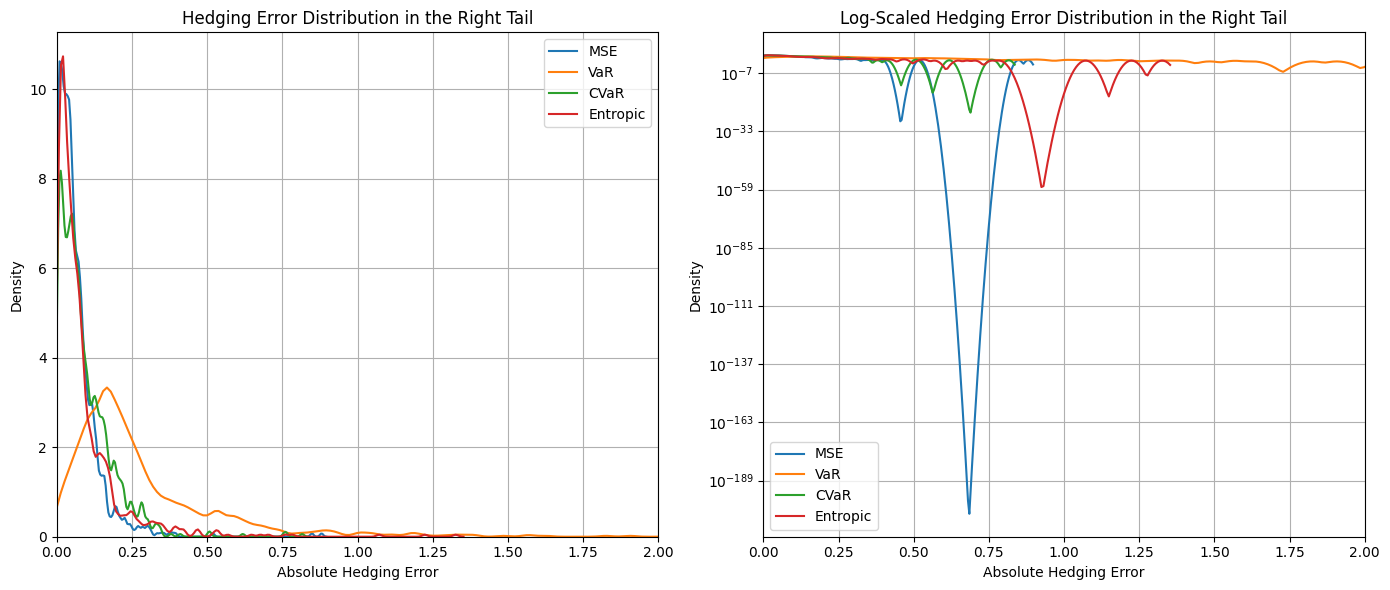

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot KDE
for name, err in errors.items():
    sns.kdeplot(err[mask], ax=axes[0], label=name, bw_adjust=0.3, clip=(0, None))

axes[0].set_xlim(0, 2)
axes[0].set_title("Hedging Error Distribution in the Right Tail")
axes[0].set_xlabel("Absolute Hedging Error")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# Plot the KDE in log-scale
for name, err in errors.items():
    sns.kdeplot(err[mask], ax=axes[1], label=name, bw_adjust=0.3, clip=(0, None))

axes[1].set_xlim(0, 2)
axes[1].set_yscale("log")
axes[1].set_title("Log-Scaled Hedging Error Distribution in the Right Tail")
axes[1].set_xlabel("Absolute Hedging Error")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Right Tail Quantile Curves

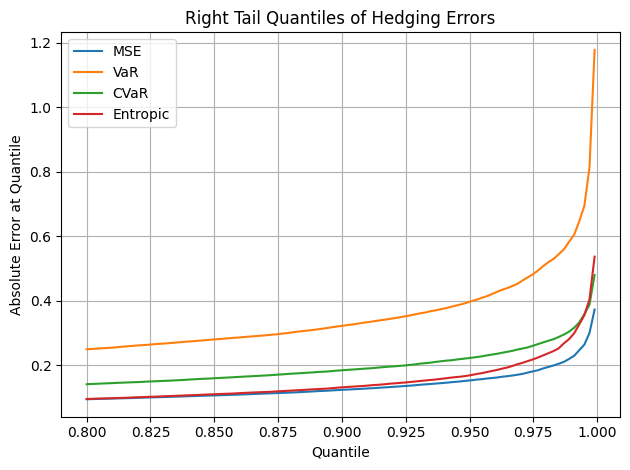

In [14]:
quantiles = np.linspace(0.80, 0.999, 100)

for name, err in errors.items():
    q_vals = [np.quantile(err, q) for q in quantiles]
    plt.plot(quantiles, q_vals, label=name)

plt.title("Right Tail Quantiles of Hedging Errors")
plt.xlabel("Quantile")
plt.ylabel("Absolute Error at Quantile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CCDF of Hedging Error

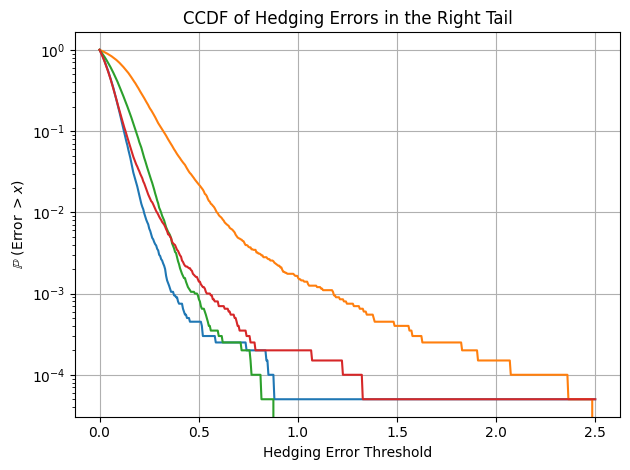

In [15]:
thresholds = np.linspace(0, 2.5, 500)

for name, err in errors.items():
    ccdf = [np.mean(err > x) for x in thresholds]
    plt.plot(thresholds, ccdf, label = name)

plt.yscale('log')
plt.xlabel("Hedging Error Threshold")
plt.ylabel('$\mathbb{P}$ (Error $> x$)')
plt.title("CCDF of Hedging Errors in the Right Tail")
plt.grid(True)
plt.tight_layout()
plt.show()

## Sharpe Ratios

In [17]:
for i, hedge in enumerate(hedges):
    sharpe = np.mean(hedge[:, 0])/np.std(hedge[:,0])
    print(f"{titles[i]:<10} Sharpe Ratio: {sharpe:.4f}")

MSE        Sharpe Ratio: 0.4283
VaR        Sharpe Ratio: 0.0591
CVaR       Sharpe Ratio: 0.4561
Entropic   Sharpe Ratio: 0.4182
